In [1]:
import random
from tqdm.notebook import tqdm
from datetime import datetime

In [2]:
import pandas as pd

file = pd.read_excel(r"master.xlsx")

In [3]:
columns = file.columns
columns

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'country-year', 'HDI for year',
       ' gdp_for_year ($) ', 'gdp_per_capita ($)', 'generation'],
      dtype='object')

## BUC Implementation

In [4]:
from mysql import connector as msql

In [5]:
connection = msql.connect(host='localhost',user='root', password='root', database='ass')
cursor = connection.cursor()

query = """SELECT country, year, generation, age, suicides_no FROM master
GROUP BY country, year, generation, age, suicides_no LIMIT 3000"""

cursor.execute(query)

In [6]:
record = cursor.fetchall() 
cursor.close()
len(record)

3000

In [7]:
import numpy as np

#### Function for BUC

In [8]:

fields = ['country', 'year', 'generation', 'age', 'suicides_no']

def BUC(input_relation, d, sequence,seq_ele, min_support): # d=0, sequence = '0'
    # new_table = "temptable" + f"{dim}"
    for dim in np.arange(d, len(fields)):
        
        cursor = connection.cursor()
        cursor.execute("SELECT " + fields[dim]+ ", COUNT(*) FROM master GROUP BY "+ fields[dim])
        current_table = cursor.fetchall()
        cursor.close()
        cardinality = len(current_table)
        data = []
        for i in range(cardinality):
            #print(seq_ele+f'{current_table[i][0]}')
            #np.savetxt(sequence+f'{dim}'+'.txt',[seq_ele+f' {current_table[i][0]} = {current_table[i][1]} '], delimiter=" ", fmt="%s")
            if current_table[i][1] >= min_support:
                cursor = connection.cursor()
                cursor.execute("SELECT * FROM master WHERE "+fields[dim]+" = "+f"\"{current_table[i][0]}\"")
                new_table = cursor.fetchall()
                cursor.close()
                data.append([seq_ele+f'{current_table[i][0]} = {current_table[i][1]}'])
                BUC(new_table, dim+1, sequence+f'{dim}', seq_ele+f' {current_table[i][0]} ', min_support)
        np.savetxt(sequence+f'{dim}'+'.txt', data, delimiter=" - ", fmt="%s") 
    #np.savetxt('cube.txt', data, delimiter=" - ", fmt="%s")  

                
    

##### Executing BUC

In [9]:
minimum_support = [700, 800, 900, 1100, 1300]
duration = []

for i in tqdm(range(len(minimum_support))):
    min_support = minimum_support[i]
    start_time = datetime.now()

    BUC(record, 0, '', '', min_support)

    end_time = datetime.now()
    dur = (end_time - start_time)
    duration.append(dur.total_seconds())

  0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
duration

[259.536101, 210.64067, 172.657538, 8.283332, 6.868788]

c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


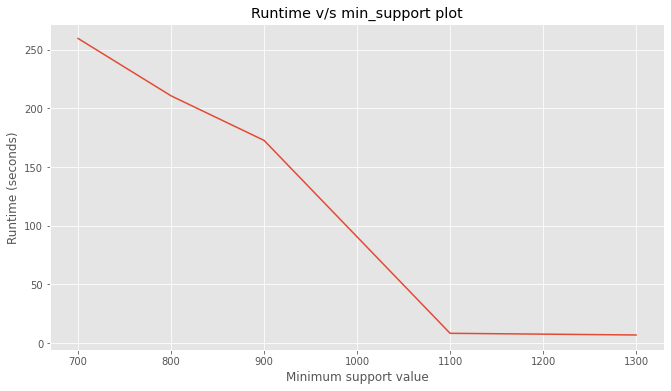

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(11, 6))
sns.lineplot(minimum_support, duration)
plt.xlabel('Minimum support value')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime v/s min_support plot')
plt.show()